The goal of this experiment is to just repeat, without guidance, what was done in Karpathy's first video lecture. I'd like to train this MLP to create a decision boundary between two diff categorical points using sklearn's "make_moons" test dataset generator

In [50]:
#Imports
import math
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from sklearn.datasets import make_moons
from homegrad.nn import Module
from homegrad.nn import Neuron
from homegrad.nn import Layer
from homegrad.nn import MLPerceptron
from homegrad.engine import * 
from homegrad.drawer import * 

%matplotlib inline

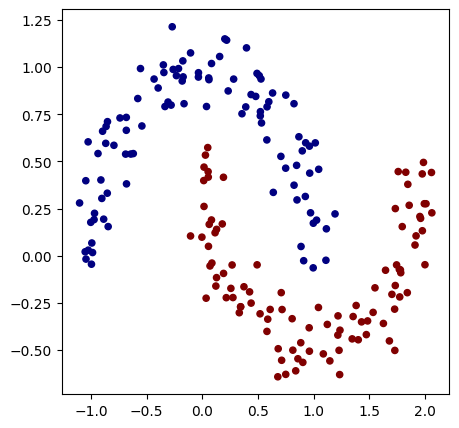

In [51]:
#Using Sklearn.datasets make_moon method to generate some pretty looking "interleaving half circles"
#Added some noise to make it less trivial
X,y = make_moons(n_samples = 200, noise = 0.10)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [52]:
#Let's figure out the shape of our input data and design our MLP from this.

print(X.shape)

#Two dimensional input. 

(200, 2)


In [53]:
#creating an instance of our homemade MLP class with 2 input neurons, a layer with 5 neurons, and another layer with 3 neurons, with 1 output neuron
#n = MLPerceptron(2,[16,16,1])


In [54]:
#for k in range(20):
#    #Forward pass
#    ypred = [n(x) for x in X]
#    loss = sum(((yout - ygt)**2 for ygt,yout in zip(y,ypred)),Value(0))
#    #Now we do the backward pass
#    for p in n.parameters():
#        p.grad = 0.0
#    loss.backward()

#    #Update. now we do gradient descent
#    ##Changing the data of each of our parameters depending on the gradient they have on the loss function. Gradient descent! 
#    for p in n.parameters():
#        p.data += -0.05 * p.grad
#    print(k,loss.data) 

In [55]:
##Ok this absolutely did not work. Let's try this again, but actually think about it this time. First of all, we should be doing batching. 
#Second of all, using MSE for this is a bit silly. Let's try hinge loss. 

#print(MLPerceptron.__init__.__code__.co_varnames)
n = MLPerceptron(2,[8,8,1], activations = ['relu', 'relu' , 'relu'])
print(n)



MLP of [Layer of [ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2), ReLu Neuron(2)], Layer of [ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8), ReLu Neuron(8)], Layer of [ReLu Neuron(8)]]


In [56]:
# loss function
def loss(batch_size=None):
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    
    # forward the model to get scores
    scores = list(map(n, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in n.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)



total_loss, acc = loss()
print(total_loss, acc)

Value(data=1.0232550804653848, grad=0) 0.36


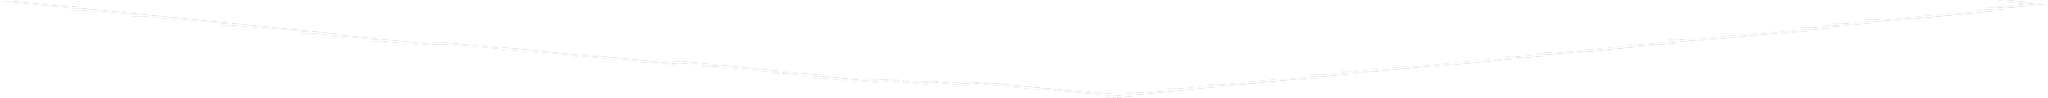

In [57]:
draw_dot(total_loss)

In [58]:
# optimization

def optimize(iters):
    for k in range(iters):
    
        # forward
        total_loss, acc = loss(32)
        
        # backward
        n.zero_grad()
        total_loss.backward()
        
        # update (sgd)
        learning_rate =  1.0 - 0.9*k/100
        for p in n.parameters():
            p.data -= learning_rate * p.grad
        
        if k % 1 == 0:
            print(f"step {k+1} loss {total_loss.data}, accuracy {acc*100}%")

optimize(100)

step 1 loss 1.0303734922841348, accuracy 37.5%
step 2 loss 1.0183622465976754, accuracy 34.375%
step 3 loss 1.0129363112393626, accuracy 37.5%
step 4 loss 1.0369278547721084, accuracy 40.625%
step 5 loss 1.012769018658319, accuracy 43.75%
step 6 loss 1.0235745815371202, accuracy 37.5%
step 7 loss 1.0331399935945313, accuracy 37.5%
step 8 loss 1.0101978297234735, accuracy 34.375%
step 9 loss 1.0250565056876764, accuracy 40.625%
step 10 loss 1.0219749761573231, accuracy 34.375%
step 11 loss 1.021371454348111, accuracy 40.625%
step 12 loss 1.0305158835731394, accuracy 25.0%
step 13 loss 1.0209992859003196, accuracy 31.25%
step 14 loss 1.009401475676118, accuracy 50.0%
step 15 loss 1.0267918283146151, accuracy 40.625%
step 16 loss 1.0274657657497297, accuracy 21.875%
step 17 loss 1.0260892320349924, accuracy 50.0%
step 18 loss 1.0228897624333393, accuracy 40.625%
step 19 loss 1.0375928374298333, accuracy 28.125%
step 20 loss 1.01957140847537, accuracy 40.625%
step 21 loss 1.023693161410318

(-1.6424409780194549, 2.107559021980545)

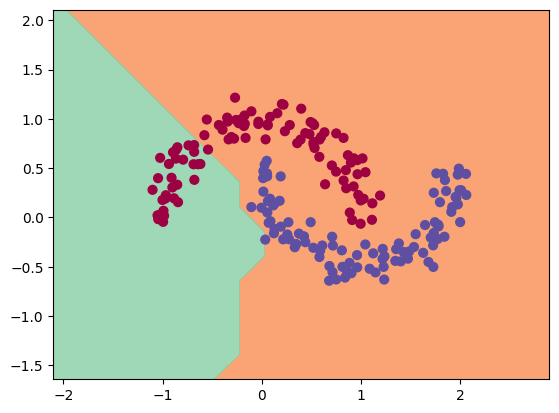

In [59]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(n, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())